In [1]:
import matplotlib.pyplot as plt

In [2]:
#!pip install python-dotenv mlflow clickhouse_connect

In [3]:
import pandas as pd
import numpy as np

In [149]:
smaple_data = {
    'timestamp': [
        '2024-12-01 00:00:14', '2024-12-02 00:00:31', '2024-12-03 00:00:48',
        '2024-12-04 00:01:07', '2024-12-06 00:01:25',
        '2024-12-07 15:33:10', '2024-12-08 15:34:09',
        '2024-12-09 15:35:08', '2024-12-10 15:37:07',
        '2024-12-14 15:39:05'
    ],
    'device': [
        'Токовый ремни Афл3.1', 'Токовый ремни Афл3.1',
        'Токовый ремни Афл3.1', 'Токовый ремни Афл3.1',
        'Токовый ремни Афл3.1',
        'Токовый ремни Афл3.1', 'Токовый ремни Афл3.1',
        'Токовый ремни Афл3.1', 'Токовый ремни Афл3.1',
        'Токовый ремни Афл3.1'
    ],
    'alpha': [
        -3.9e-05, -1.9775e-05, -5.975e-06, -4.97e-08, 0.4784,
        -3.978475e-03, -7.978475e-05, 1.978475e-09, 4.978475e-02, 0.97
    ]
}

df = pd.DataFrame(smaple_data)

df['timestamp'] = pd.to_datetime(df['timestamp'])

<Axes: >

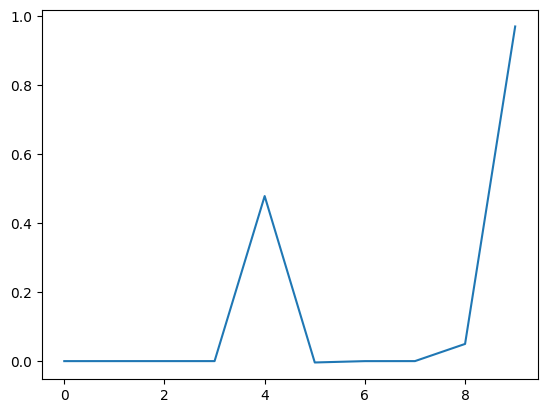

In [150]:
df.alpha.plot()

In [189]:
# Произошла поломка -- 2024-12-06 18:00:00 поменяли деталь -- 2024-12-06 01:00:00, почнинили -- 2024-12-06 19:00:00. Затем снова поломка к '2024-12-14 12:35:00'
# Таким образом было 2 пробега, двух разных деталей - 2 разных id этих деталей

exploitationDates = {1:['2024-12-01 00:00:00', '2024-12-06 01:00:00'], 2:['2024-12-06 19:00:00', '2024-12-12 12:35:00']}

# Можно и другие варианты разметки времени эксплуатации сделать

# Достаем данные

In [190]:
data = df.copy()

In [191]:
data

,timestamp,device,alpha
0,2024-12-01 00:00:14,Токовый ремни Афл3.1,-3.900000e-05
1,2024-12-02 00:00:31,Токовый ремни Афл3.1,-1.977500e-05
2,2024-12-03 00:00:48,Токовый ремни Афл3.1,-5.975000e-06
3,2024-12-04 00:01:07,Токовый ремни Афл3.1,-4.970000e-08
4,2024-12-06 00:01:25,Токовый ремни Афл3.1,4.784000e-01
5,2024-12-07 15:33:10,Токовый ремни Афл3.1,-3.978475e-03
6,2024-12-08 15:34:09,Токовый ремни Афл3.1,-7.978475e-05
7,2024-12-09 15:35:08,Токовый ремни Афл3.1,1.978475e-09
8,2024-12-10 15:37:07,Токовый ремни Афл3.1,4.978475e-02
9,2024-12-14 15:39:05,Токовый ремни Афл3.1,9.700000e-01


Допустим, у нас есть json с метками начала и конца эксплуатации конкретного оборудования под id = 1 и id = 2

In [192]:
# Преобразуем в datetime для pandas
for key in exploitationDates:
    exploitationDates[key][0] = pd.to_datetime(exploitationDates[key][0])
    exploitationDates[key][1] = pd.to_datetime(exploitationDates[key][1])

In [193]:
exploitationDates

{1: [Timestamp('2024-12-01 00:00:00'), Timestamp('2024-12-06 01:00:00')],
 2: [Timestamp('2024-12-06 19:00:00'), Timestamp('2024-12-12 12:35:00')]}

In [119]:
# def assign_session_id(row, column_date_Name, exploitationDates):
#     for session_id, (start, end) in exploitationDates.items():
#         if start <= row[column_date_Name] < end:
#             return session_id
#     return None

In [172]:
# data.apply(assign_session_id, args=(['timestamp', exploitationDates]), axis=1)

In [196]:
def assign_session_id_rul(df, column_date_Name, exploitationDates):
    df = df.copy()
    df[['id','rul']] = None
    for session_id, (start, end) in exploitationDates.items():
        df.loc[df[column_date_Name].between(start, end), ['id']] = session_id
        df.loc[df['id'] == session_id, ['rul']] = (end - df[df.id == session_id][column_date_Name]).dt.total_seconds()
        # В задаче rul используют переменную cycle index для сохранения последовательности сигнала (с timestamp не все модели хорошо работают)
        # Пока пусть будет просто incremental index (плохо если разница во времени между сигналами не постоянная)
        df.loc[df['id'] == session_id, ['cycle_index']] = df[df['id'] == session_id].reset_index().index
    return df

In [197]:
data_ruled = assign_session_id_rul(data, 'timestamp', exploitationDates)

In [200]:
data_ruled

,timestamp,device,alpha,id,rul,cycle_index
0,2024-12-01 00:00:14,Токовый ремни Афл3.1,-3.900000e-05,1,435586.0,0.0
1,2024-12-02 00:00:31,Токовый ремни Афл3.1,-1.977500e-05,1,349169.0,1.0
2,2024-12-03 00:00:48,Токовый ремни Афл3.1,-5.975000e-06,1,262752.0,2.0
3,2024-12-04 00:01:07,Токовый ремни Афл3.1,-4.970000e-08,1,176333.0,3.0
4,2024-12-06 00:01:25,Токовый ремни Афл3.1,4.784000e-01,1,3515.0,4.0
5,2024-12-07 15:33:10,Токовый ремни Афл3.1,-3.978475e-03,2,421310.0,0.0
6,2024-12-08 15:34:09,Токовый ремни Афл3.1,-7.978475e-05,2,334851.0,1.0
7,2024-12-09 15:35:08,Токовый ремни Афл3.1,1.978475e-09,2,248392.0,2.0
8,2024-12-10 15:37:07,Токовый ремни Афл3.1,4.978475e-02,2,161873.0,3.0
9,2024-12-14 15:39:05,Токовый ремни Афл3.1,9.700000e-01,None,None,NaN


# Обучение

In [212]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [202]:
data_ruled.dropna(inplace=True)

In [203]:
data_ruled

,timestamp,device,alpha,id,rul,cycle_index
0,2024-12-01 00:00:14,Токовый ремни Афл3.1,-3.900000e-05,1,435586.0,0.0
1,2024-12-02 00:00:31,Токовый ремни Афл3.1,-1.977500e-05,1,349169.0,1.0
2,2024-12-03 00:00:48,Токовый ремни Афл3.1,-5.975000e-06,1,262752.0,2.0
3,2024-12-04 00:01:07,Токовый ремни Афл3.1,-4.970000e-08,1,176333.0,3.0
4,2024-12-06 00:01:25,Токовый ремни Афл3.1,4.784000e-01,1,3515.0,4.0
5,2024-12-07 15:33:10,Токовый ремни Афл3.1,-3.978475e-03,2,421310.0,0.0
6,2024-12-08 15:34:09,Токовый ремни Афл3.1,-7.978475e-05,2,334851.0,1.0
7,2024-12-09 15:35:08,Токовый ремни Афл3.1,1.978475e-09,2,248392.0,2.0
8,2024-12-10 15:37:07,Токовый ремни Афл3.1,4.978475e-02,2,161873.0,3.0


In [222]:
features = data_ruled[['alpha', 'cycle_index']]
target = data_ruled['rul']

## Разделение данных на обучающую и тестовую выборки

In [223]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Обучение модели

In [224]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Оценка модели

In [225]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Coefficient of determination: {r2}')

Mean Squared Error: 162645637.52104977
Coefficient of determination: 0.935941087907787


## Прогнозирование на новых данных

In [227]:
new_data = pd.DataFrame({'alpha': [0.1e-04,0.1], 'cycle_index': [5,6]})
predicted_rul = model.predict(new_data)
print(f'Predicted RUL: {predicted_rul}')

Predicted RUL: [143933.27 116400.58]


40 часов осталось -> 32 часа осталось после перехода на след цикл

In [221]:
# Можно поиграться с моделями и параметрами для сохранения в MLflow
params = {"n_estimators": 1.0, "random_state": 42}

Важно, чтобы данные были собраны регулярно, чтобы разница между наблюдениями cycle_index была постоянна, либо использовать timestamp